# Train a Simplicial Attention Network (SAN)

In this notebook, we will create and train a High Skip Network in the simplicial complex domain, as proposed in the paper by [Hajij et. al : High Skip Networks: A Higher Order Generalization of Skip Connections (2022)](https://openreview.net/pdf?id=Sc8glB-k6e9). 

We train the model to perform binary node classification using the KarateClub benchmark dataset. 

The equations of one layer of this neural network are given by:

🟥 $\quad m_{{y \rightarrow z}}^{(0 \rightarrow 0)} = \sigma ((A_{\uparrow,0})_{xy} \cdot h^{t,(0)}_y \cdot \Theta^{t,(0)1})$    (level 1)

🟥 $\quad m_{z \rightarrow x}^{(0 \rightarrow 0)}  = (A_{\uparrow,0})_{xy} \cdot m_{y \rightarrow z}^{(0 \rightarrow 0)} \cdot \Theta^{t,(0)2}$    (level 2)

🟥 $\quad m_{{y \rightarrow z}}^{(0 \rightarrow 1)}  = \sigma((B_1^T)_{zy} \cdot h_y^{t,(0)} \cdot \Theta^{t,(0 \rightarrow 1)})$    (level 1)

🟥 $\quad m_{z \rightarrow x)}^{(1 \rightarrow 0)}  = (B_1)_{xz} \cdot m_{z \rightarrow x}^{(0 \rightarrow 1)} \cdot \Theta^{t, (1 \rightarrow 0)}$    (level 2)

🟧 $\quad m_{x}^{(0 \rightarrow 0)}  = \sum_{z \in \mathcal{L}_\uparrow(x)} m_{z \rightarrow x}^{(0 \rightarrow 0)}$

🟧 $\quad m_{x}^{(1 \rightarrow 0)}  = \sum_{z \in \mathcal{C}(x)} m_{z \rightarrow x}^{(1 \rightarrow 0)}$

🟩 $\quad m_x^{(0)}  = m_x^{(0 \rightarrow 0)} + m_x^{(1 \rightarrow 0)}$

🟦 $\quad h_x^{t+1,(0)}  = I(m_x^{(0)})$

Where the notations are defined in [Papillon et al : Architectures of Topological Deep Learning: A Survey of Topological Neural Networks (2023)](https://arxiv.org/abs/2304.10031).

In [7]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from toponetx import SimplicialComplex, CellComplex
from torch_geometric.datasets import TUDataset
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from topomodelx.nn.simplicial.hsn_layer import HSNLayer
from get_cells import compute_simplices

If GPU's are available, we will make use of them. Otherwise, this will run on CPU.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Pre-processing

## Import data ##

We import a subset of MUTAG, a benchmark dataset for graph classification. 

We then lift each graph into our topological domain of choice, here: a simplicial complex.

We also retrieve:
- input signals `x_0` and `x_1` on the nodes (0-cells) and edges (1-cells) for each simplicial: these will be the model's inputs,
- a binary classification label `y` associated to the simplicial complex.

In [13]:
dataset = TUDataset(
    root="/tmp/PROTEINS", name="PROTEINS", use_edge_attr=True, use_node_attr=True
)
dataset = dataset[:20]
sc_list = []
x_0_list = []
# x_1_list = []
y_list = []
for graph in dataset:
    simplicial_complex = SimplicialComplex(to_networkx(graph))
    simplices = compute_simplices(x=graph.x, edges=graph.edge_index, max_k=3)
    simplicial_complex.add_simplices_from(simplices)
    sc_list.append(simplicial_complex)
    x_0_list.append(graph.x)
    # x_1_list.append(graph.edge_attr)
    y_list.append(int(graph.y))

i_sc = 0
print(f"Features on nodes for the {i_sc}th simplicial complex: {x_0_list[i_sc].shape}.")
# print(f"Features on edges for the {i_sc}th simplicial complex: {x_1_list[i_sc].shape}.")
print(f"Label of {i_sc}th simplicial complex: {y_list[i_sc]}.")

Features on nodes for the 0th simplicial complex: torch.Size([42, 4]).
Label of 0th simplicial complex: 0.


## Define neighborhood structures. ##

Now we retrieve the neighborhood structures (i.e. their representative matrices) that we will use to send messges on the domain. In this case, we need the boundary matrix (or incidence matrix) $B_1$ and the adjacency matrix $A_{\uparrow,0}$ on the nodes. For a santiy check, we show that the shape of the $B_1 = n_\text{nodes} \times n_\text{edges}$ and $A_{\uparrow,0} = n_\text{nodes} \times n_\text{nodes}$. We also convert the neighborhood structures to torch tensors.

In [9]:
simplicial_complex.simplices

SimplexView([(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (0, 20), (0, 22), (0, 23), (1, 2), (1, 20), (1, 21), (2, 3), (2, 21), (25, 3), (26, 3), (4, 5), (4, 6), (25, 4), (26, 4), (5, 6), (26, 5), (6, 7), (8, 7), (9, 7), (8, 9), (8, 10), (9, 10), (10, 11), (10, 12), (11, 12), (11, 13), (12, 13), (12, 14), (13, 14), (13, 15), (14, 15), (16, 14), (17, 14), (16, 15), (17, 15), (16, 17), (18, 19), (18, 23), (24, 18), (19, 23), (24, 19), (20, 21), (20, 22), (22, 23), (24, 22), (24, 23), (25, 26)])

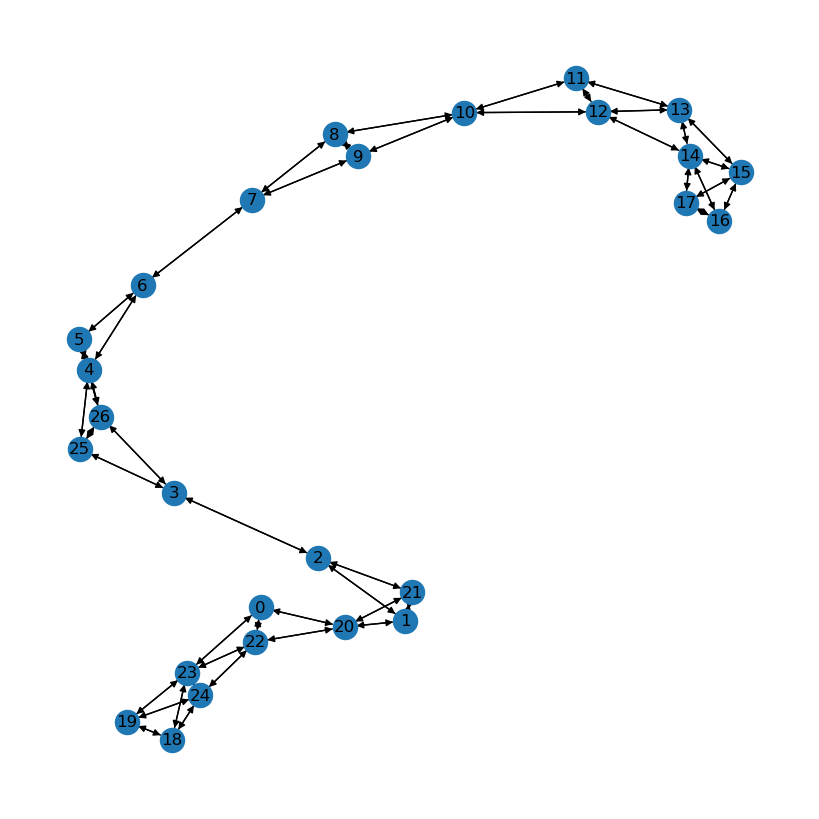

In [10]:
nx.draw(to_networkx(graph), with_labels=True)

In [46]:
cell_complex = CellComplex(to_networkx(graph))

In [47]:
cell_complex.

CellView([])

In [48]:
incidence_2 = simplicial_complex.incidence_matrix(rank=2)
incidence_1 = simplicial_complex.incidence_matrix(rank=1)
adjacency_0 = simplicial_complex.adjacency_matrix(rank=0)

ValueError: input dimenion cannat be larger than the dimension of the complex, got 2

In [4]:
incidence_1 = simplicial_complex.incidence_matrix(rank=1)
adjacency_0 = simplicial_complex.adjacency_matrix(rank=0)

incidence_1 = torch.from_numpy(incidence_1.todense()).to_sparse()
adjacency_0 = torch.from_numpy(adjacency_0.todense()).to_sparse()

## Import signal ##

Since our task will be node classification, we must retrieve an input signal on the nodes. The signal will have shape $n_\text{nodes} \times$ in_channels, where in_channels is the dimension of each cell's feature. Here, we have in_channels = channels_nodes $ = 34$. This is because the Karate dataset encodes the identity of each of the 34 nodes as a one hot encoder.

In [5]:
x_nodes = dataset[0].x
print(x_nodes.shape)
channels_nodes = x_nodes.shape[-1]

torch.Size([34, 34])


## Define binary labels
We retrieve the labels associated to the nodes of each input simplex. In the KarateClub dataset, two social groups emerge. So we assign binary labels to the nodes indicating of which group they are a part.

We convert the binary labels into one-hot encoder form, and keep the first four nodes' true labels for the purpose of testing.

In [8]:
y = np.array(
    [
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        0,
        1,
        1,
        1,
        1,
        0,
        0,
        1,
        1,
        0,
        1,
        0,
        1,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
    ]
)
y_true = np.zeros((34, 2))
y_true[:, 0] = y
y_true[:, 1] = 1 - y
y_test = y_true[:4]
y_train = y_true[-30:]

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [11]:
incidence_1.shape

torch.Size([34, 78])

In [17]:
incidence_2 = simplex.incidence_matrix(rank=2)

ValueError: input dimenion cannat be larger than the dimension of the complex, got 2

# Create the Neural Network

Using the HSNLayer class, we create a neural network with stacked layers. A linear layer at the end produces an output with shape $n_\text{nodes} \times 2$, so we can compare with our binary labels.

In [6]:
class HSN(torch.nn.Module):
    """High Skip Network Implementation for binary node classification.

    Parameters
    ---------
    channels : int
        Dimension of features
    n_layers : int
        Amount of message passing layers.

    """

    def __init__(self, channels, n_layers=2):
        super().__init__()
        layers = []
        for _ in range(n_layers):
            layers.append(
                HSNLayer(
                    channels=channels,
                )
            )
        self.linear = torch.nn.Linear(channels, 2)
        self.layers = layers

    def forward(self, x_0, incidence_1, adjacency_0):
        """Forward computation.

        Parameters
        ---------
        x_0 : tensor
            shape = [n_nodes, channels]
            Node features.

        incidence_1 : tensor
            shape = [n_nodes, n_edges]
            Boundary matrix of rank 1.

        adjacency_0 : tensor
            shape = [n_nodes, n_nodes]
            Adjacency matrix (up) of rank 0.

        Returns
        --------
        _ : tensor
            shape = [n_nodes, 2]
            One-hot labels assigned to nodes.

        """
        for layer in self.layers:
            x_0 = layer(x_0, incidence_1, adjacency_0)
        return torch.sigmoid(self.linear(x_0))

# Train the Neural Network

We specify the model with our pre-made neighborhood structures and specify an optimizer.

In [7]:
model = HSN(
    channels=channels_nodes,
    n_layers=10,
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.4)

The following cell performs the training, looping over the network for a low number of epochs.

In [8]:
test_interval = 2
num_epochs = 5
for epoch_i in range(1, num_epochs + 1):
    epoch_loss = []
    model.train()
    optimizer.zero_grad()

    y_hat = model(x_nodes, incidence_1, adjacency_0)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(
        y_hat[-len(y_train) :].float(), y_train.float()
    )
    epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

    y_pred = torch.where(y_hat > 0.5, torch.tensor(1), torch.tensor(0))
    accuracy = (y_pred == y_hat).all(dim=1).float().mean().item()
    print(
        f"Epoch: {epoch_i} loss: {np.mean(epoch_loss):.4f} Train_acc: {accuracy:.4f}",
        flush=True,
    )
    if epoch_i % test_interval == 0:
        with torch.no_grad():
            y_hat_test = model(x_nodes, incidence_1, adjacency_0)
            y_pred_test = torch.sigmoid(y_hat_test).ge(0.5).float()
            test_accuracy = (
                torch.eq(y_pred_test[: len(y_test)], y_test)
                .all(dim=1)
                .float()
                .mean()
                .item()
            )
            print(f"Test_acc: {test_accuracy:.4f}", flush=True)

Epoch: 1 loss: 0.7296 Train_acc: 0.0000
Epoch: 2 loss: 0.6831 Train_acc: 0.0000
Test_acc: 0.0000
Epoch: 3 loss: 0.6561 Train_acc: 0.0000
Epoch: 4 loss: 0.6573 Train_acc: 0.0000
Test_acc: 0.0000
Epoch: 5 loss: 0.6550 Train_acc: 0.0000
